# Resolução da lista 3 de NLP

## Alunos:
  - Eduardo Brasil Araujo
  - Gideão Pinheiro"

# Questão 1

In [1]:
import transformers as ppb
import pandas as pd
import numpy as np
import torch

e:\localhost\Desktop\dor-repos\computer-science\natural-language-processing\repo\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

distil_config = ppb.DistilBertConfig(
    max_position_embeddings=1024 * 10,
)

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, config=distil_config, ignore_mismatched_sizes=True)
model = model_class.from_pretrained(pretrained_weights, config=distil_config, ignore_mismatched_sizes=True)

Some weights of DistilBertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized because the shapes did not match:
- distilbert.embeddings.position_embeddings.weight: found shape torch.Size([512, 768]) in the checkpoint and torch.Size([10240, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
df = pd.read_csv('../datasets/preprocessed_website_classification.csv')

In [4]:
df.dropna(inplace=True)

In [5]:
data = df[['cleaned_website_text', 'Category']]
data = data[data.Category.isin(['Games', 'Food'])]
data = data.sample(frac=1, random_state=101).reset_index(drop=True)

In [11]:
batch_1 = data.rename(columns={'cleaned_website_text': 0, 'Category': 1})[:20]

In [12]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [13]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

In [14]:
np.array(padded).shape

(20, 1100)

In [15]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(20, 1100)

In [16]:
input_ids = torch.tensor(padded, device=torch.device('cuda'))
attention_mask = torch.tensor(attention_mask, device=torch.device('cuda'))

model.to(torch.device('cuda'))

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [17]:
features = last_hidden_states[0][:,0,:].to(torch.device('cpu')).numpy()

In [18]:
labels = batch_1[1]

## Prep

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [20]:
def get_all(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision_1 = precision_score(y_test, y_pred, pos_label='Games')
    recall_1 = recall_score(y_test, y_pred, pos_label='Games')
    f1_1 = f1_score(y_test, y_pred, pos_label='Games')
    precision_2 = precision_score(y_test, y_pred, pos_label='Food')
    recall_2 = recall_score(y_test, y_pred, pos_label='Food')
    f1_2 = f1_score(y_test, y_pred, pos_label='Food')
    return confusion, accuracy, precision_1, recall_1, f1_1, precision_2, recall_2, f1_2

In [21]:
def get_values(y_test, y_pred):
    conf, acc, prec_1, recl_1, f1_1, prec_2, recl_2, f1_2 = get_all(y_test, y_pred)
    print('Confusion:\n', conf)
    print('Accuracy: ', acc)
    print('Precision (Games): ', prec_1)
    print('Recall (Games): ', recl_1)
    print('F1 (Games): ', f1_1)
    print('Precision (Food): ', prec_2)
    print('Recall (Food): ', recl_2)
    print('F1 (Food): ', f1_2)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, shuffle=True, random_state=123)

## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
lr = LogisticRegression(random_state=101).fit(X_train, y_train)

In [25]:
get_values(y_test, lr.predict(X_test))

Confusion:
 [[2 0]
 [4 0]]
Accuracy:  0.3333333333333333
Precision (Games):  0.0
Recall (Games):  0.0
F1 (Games):  0.0
Precision (Food):  0.3333333333333333
Recall (Food):  1.0
F1 (Food):  0.5


e:\localhost\Desktop\dor-repos\computer-science\natural-language-processing\repo\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Naive-Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB

In [28]:
gnb = GaussianNB().fit(X_train, y_train)

In [29]:
get_values(y_test, gnb.predict(X_test))

Confusion:
 [[2 0]
 [2 2]]
Accuracy:  0.6666666666666666
Precision (Games):  1.0
Recall (Games):  0.5
F1 (Games):  0.6666666666666666
Precision (Food):  0.5
Recall (Food):  1.0
F1 (Food):  0.6666666666666666


## SVM

In [30]:
from sklearn.svm import SVC

In [32]:
svc = SVC().fit(X_train, y_train)

In [33]:
get_values(y_test, svc.predict(X_test))

Confusion:
 [[2 0]
 [4 0]]
Accuracy:  0.3333333333333333
Precision (Games):  0.0
Recall (Games):  0.0
F1 (Games):  0.0
Precision (Food):  0.3333333333333333
Recall (Food):  1.0
F1 (Food):  0.5


e:\localhost\Desktop\dor-repos\computer-science\natural-language-processing\repo\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Análise dos resultados

Os resultados da matriz de confusão apresentaram-se idênticos no modelo de
regressão logística e SVM, com isso as demais métricas foram as mesmas, mas
o que apresentou melhores resultados foi o de Naive-Bayes, com acurácia maior
que o mínimo aceitável de 50%. O desenvolvimento desta questão se provou
desafiador, uma vez que para treinar o modelo requereu uma quantidade
de memória muito alta; e essa dificuldade se mostrou nos resultados. Provavelmente
uma melhor otimização ou entendimento do modelo poderia melhorar os resultados.

O arranjo com o Naive-Bayes apresenta-se interessante para uma situação em que
é necessário saber com certeza se o texto dado é de fato um texto sobre games,
uma vez que apresentou uma precisão de 100%. Os outros modelos são péssimos em tudo.

# Question 2

In [11]:
from bertopic import BERTopic
import pandas as pd

e:\localhost\Desktop\dor-repos\computer-science\natural-language-processing\repo\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
df = pd.read_csv('../datasets/website_classification.csv')

In [13]:
data = df[df['cleaned_website_text'].apply(lambda x: isinstance(x, str))]

In [14]:
data = data.cleaned_website_text

In [15]:
model = BERTopic(language='english')
topics, probs = model.fit_transform(data)

## Todos os tópicos da gerados com a base e suas palvras mais frequentes

In [17]:
model.get_topics()

{-1: [('sport', 0.016577594664465553),
  ('car', 0.011662307106545783),
  ('new', 0.011023681334278845),
  ('close', 0.009730651636810828),
  ('service', 0.00962132721585058),
  ('rental', 0.009609883860660955),
  ('home', 0.009524244275972824),
  ('click', 0.009384549883012945),
  ('badminton', 0.009315051893132165),
  ('information', 0.009202277665754134)],
 0: [('group', 0.011199841484864234),
  ('edit', 0.0100934662197763),
  ('science', 0.009982882702392736),
  ('system', 0.009828057949111256),
  ('file', 0.009461110538236102),
  ('software', 0.009369662947404399),
  ('student', 0.00936882939112789),
  ('theory', 0.008895846047721638),
  ('lesson', 0.00885789425045719),
  ('business', 0.008835806241075097)],
 1: [('news', 0.03600893817749506),
  ('world', 0.016243480130335945),
  ('late', 0.01548403772780324),
  ('new', 0.014382530572539761),
  ('trump', 0.013934392040669069),
  ('coronavirus', 0.013709451024422267),
  ('vaccine', 0.013366367617877854),
  ('ago', 0.011674683203315

## Visualização dos dados

In [19]:
model.visualize_barchart()

In [7]:
model.visualize_topics()

# Question 3

Abaixo está a criação do prompt utilizando o chat-GPT na versão 3.5
A criação do prompt segue o que foi indicado [neste artigo](https://arxiv.org/abs/2304.10428)
Na primeira etapa utilizamos a frase "I am an excelent linguist" para que as respostas sejam dadas utilizando os conhecimentos de linguística. 
Ainda nesta etapa informamos qual a tarefa queremos que seja realizada e informamos que as entidades são do tipo "animal" e após isso indicamos onde estão os exemplos.

Na segunda etapa damos alguns exemplos, fornecendo inputs parecidos com os que ele receberia e outputs que mostram o padrão da resposta.

Após isso, pedimos para que ele complete os outputs e passamos 5 inputs para que ele identifique as categorias.

In [8]:
from IPython.display import Image

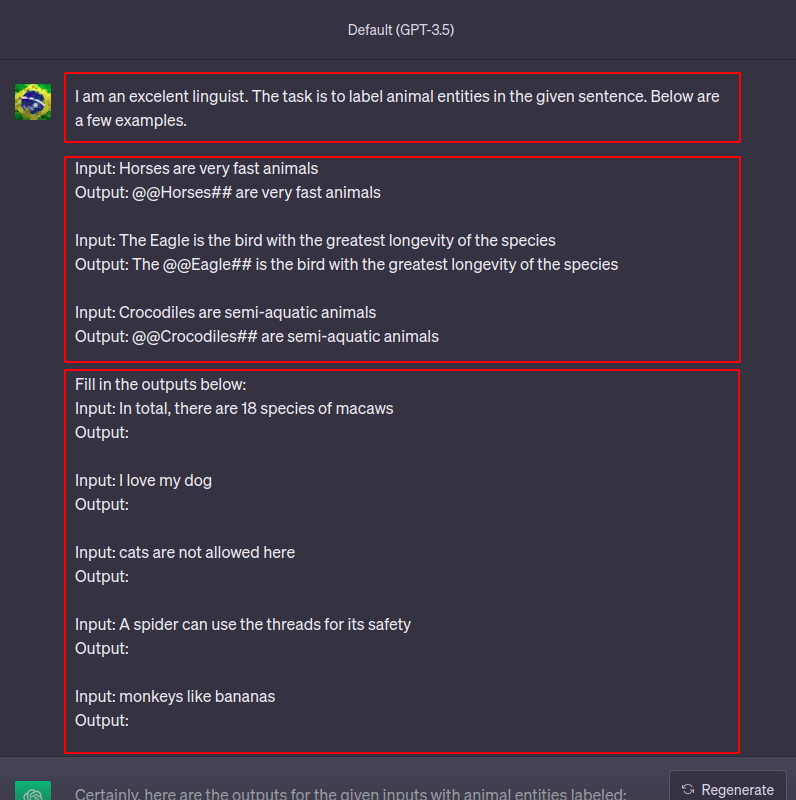

In [9]:
Image(filename='../assets/2023-10-08_11-25.png')

O resultado é mostrado abaixo:

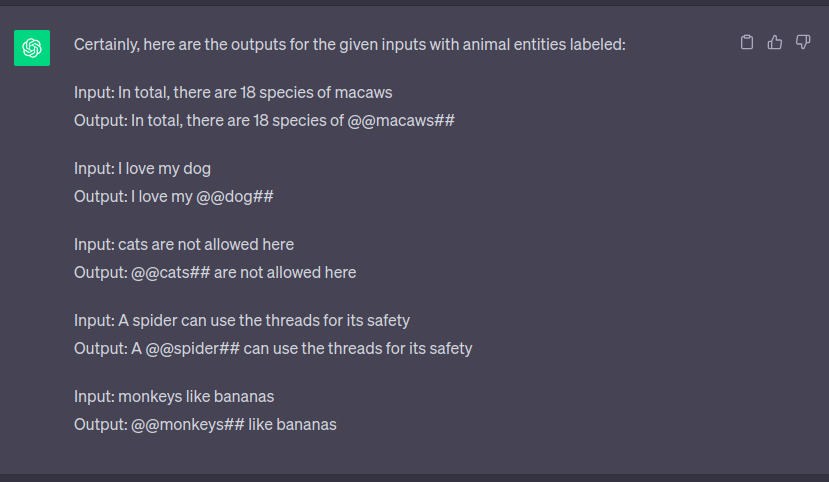

In [10]:
Image('../assets/2023-10-08_11-25_1.png')

# Question 4

## Tratando dos dados

In [1]:
import pandas as pd
import random
from unidecode import unidecode

In [2]:
df = pd.read_csv('../datasets/website_classification.csv')

In [3]:
data = df.cleaned_website_text.tolist()

In [4]:
random.seed(101)
selected_data = random.sample(data, 1000)

In [5]:
new_data = [' '.join(dd.split(' ')[:10 - random.randint(0, 6)]) for dd in selected_data]

In [6]:
print(new_data)

['japanese female facial expression jaffe dataset zenodo specifications japanese female', 'camera news review feature digital', 'online grocery shopping online', 'aafp home american academy family physicians american academy family', 'festive recipe butter sev shahi paneer sk khazana bhajanee chakli', 'toggle navigation menu lang lang cultureui home find hotel', 'home lightningstrike studios lightningstrike studios', 'online thesis number theory online s number theory', 'good online photography courses creativelive online photography', 'extensible markup language xml extensible markup language xml', 'deviantart discover large online art gallery', 'home ministry finance goi home department expenditure nodal', 'agent choice agents choice', 'photographers inspire online community photographer extensive photo', 'welcome degos disease support network network supporter information hub affect', 'vegan recipes angela liddon oh glow award win', 'download new mp3 songs online latest bollywood so

In [7]:
with open('titulos.txt', 'w') as fp:
    for title in new_data:    
        fp.write(f'{unidecode(title)}\n')

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
with open('titulos.txt', 'r') as data:
    dataset = ['<|title|>' + x.strip() for x in data.readlines()]

In [10]:
train, eval = train_test_split(dataset, train_size=.9, random_state=2020)
print('Training size: ' + str(len(train)))
print('Evaluation size: ' + str(len(eval)))

Training size: 900
Evaluation size: 100


In [11]:
with open('train_tmp.txt', 'w') as file_handle:
    file_handle.write('<|endoftext|>'.join(train))
    
with open('eval_tmp.txt', 'w') as file_handle:
    file_handle.write('<|endoftext|>'.join(eval))

In [12]:
!python ../vendor/transformers/examples/pytorch/language-modeling/run_clm.py \
--model_type gpt2-medium \
--model_name_or_path gpt2-medium \
--train_file "train_tmp.txt" \
--do_train \
--validation_file "eval_tmp.txt" \
--do_eval \
--per_gpu_train_batch_size 1 \
--save_steps -1 \
--num_train_epochs 5 \
--fp16 \
--output_dir="./fine_tunning/output/"

10/20/2023 14:29:04 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: True
10/20/2023 14:29:04 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_

Using custom data configuration default-094845dc75a0e5c1
Loading Dataset Infos from e:\localhost\Desktop\dor-repos\computer-science\natural-language-processing\repo\venv\lib\site-packages\datasets\packaged_modules\text
Generating dataset text (C:/Users/localhost/.cache/huggingface/datasets/text/default-094845dc75a0e5c1/0.0.0/c4a140d10f020282918b5dd1b8a49f0104729c6177f60a6b49ec2a365ec69f34)

Checksum Computation took 0.0 min

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 86.96it/s]
Generating train split

Generating train split: 0 examples [00:00, ? examples/s]
Generating train split: 1 examples [00:00, 42.00 examples/s]
Generating validation split

Generating validation split: 0 examples [00:00, ? examples/s]
Generating validation split: 1 examples [00:00, 90.79 examples/s]
Unable to verify splits sizes.
Dataset text downloaded and prepared to C:/Users/localhost/.cache/huggingface/datasets/text/default-094845dc75a0e5c1/0.0.0/c4a140d10f020282918b5dd1b8a49f0104729c6177f60a6b4

In [19]:
from transformers import GPT2LMHeadModel
from transformers import GPT2Tokenizer
import numpy as np

In [22]:
model = GPT2LMHeadModel.from_pretrained('fine_tunning/output')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# input_ids = tokenizer.encode('simple seed')

In [24]:
generated_text_samples = model.generate(
    max_length=150,
    num_return_sequences=5,
    no_repeat_ngram_size=2,
    repetition_penalty=1.5,
    top_p=0.92,
    temperature=.85,
    do_sample=True,
    top_k=125,
    early_stopping=True
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [26]:
for i, beam in enumerate(generated_text_samples):
    print(f'{i}: {tokenizer.decode(beam, skip_special_tokens=True)}\n')

0: <|title>The Sims 4 Walkthrough (4/2)
</div><br /td style="margin: 0cm 1.5in"> <|date desc="" title="#" rel="nofollow"><||portrait width="/large-image?width=400px&height=-200%"></||cite pageurls photo yahoo! photos link world news pictures latest story view update upload current trend time event timelime interval follow custom date user sign up welcome contact joshua tjones mike wampler community forums discussion forum free sim chat game rules buy gift offer pc platform license program topic sell virtual life experience visit wikipedia site home products tutorial services help breaking bad live tv episode episodes show

1: <|title>A free photo chat room for real people
.com/realpeoplechatroom is a FREE online video & photography community on. com site hosting quality live chats rooms videos photos contact welcome read more news breaking tv show results add your own captions gallery howledarkhow radio commentary storyteller stories collection help calendar day outlook perspective spe